# Projet 6 : Catégorisez automatiquement des questions
# <u>B. Topic Modeling</u> <br/>

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from bs4 import BeautifulSoup
import unicodedata
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from contractions import CONTRACTION_MAP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter

from sklearn.model_selection import GridSearchCV

from sklearn import model_selection, metrics
from sklearn.decomposition import NMF, LatentDirichletAllocation

%matplotlib inline

# 1. Chargement des données pré-traitées

Nos données sont réparties dans 5 fichiers représentant une taille totale de 0,12Go.

In [3]:
df = pd.read_csv('cleaned_data.csv')
#replace NaN by empty string
df = df.replace(np.nan, '', regex=True)

In [3]:
df.shape

(64432, 7)

In [4]:
df.head()

,TITLE,BODY,SCORE,TAGS,TITLE_P,BODY_P,TAGS_P
0,Java generics variable <T> value,<p>At the moment I am using the following code...,6,<java><generics>,java gener variabl valu,moment use follow code filter jpa valu getclas...,java generics
1,How a value typed variable is copied when it i...,<blockquote>\n <p>Swift's string type is a va...,6,<swift><function><value-type>,valu type variabl copi pass function hold copi,swift string type valu type creat new string v...,swift function value-type
2,Error while waiting for device: The emulator p...,<p>I am a freshman for the development of the ...,6,<android><android-studio><android-emulator><avd>,error wait devic emul process avd kill,freshman develop andriod suffer odd question r...,android android-studio android-emulator avd
3,gulp-inject not working with gulp-watch,<p>I am using gulp-inject to auto add SASS imp...,10,<javascript><node.js><npm><gulp><gulp-watch>,gulp inject work gulp watch,use gulp inject auto add sass import newli cre...,javascript node.js npm gulp gulp-watch
4,React - Call function on props change,<p>My TranslationDetail component is passed an...,12,<reactjs><react-router>,react call function prop chang,translationdetail compon pass id upon open bas...,reactjs react-router


In [23]:
i=1900
with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
    print("-",df.loc[i].BODY)
    print("+",df.loc[i].BODY_P)
    #pd.set_option('display.max_colwidth', -1)


- <p>I'm currently making a web shop with WooCommerce and i have this cart made that you can access at any page at any time, you can update the quantity of a product within the cart itself. The problem happens whenever i do this some values get messed up. For example when i try to get <code>WC()-&gt;cart-&gt;total</code> it returns 0. </p>

<p>But when i go to the checkout page it shows all the correct cart data, so this makes me think i'm missing some <code>action</code> i have to run after adjusting something in the cart. I've been looking trough the <code>set_quantity()</code> functions and it automatically refreshes total with <code>$this-&gt;calculate_totals();</code> (tried it manually as well).</p>

<p><strong>Ajax function:</strong></p>

<pre><code>public function set_quantity($direction = false, $product_id) {
    $response = array();
    $justOne = false;

    if($_GET['data']['direction'] &amp;&amp; $_GET['data']['product_id']) {
        $direction = $_GET['data']['direction

# 2. Transformation des données

## 2.1 Echantillonage

Travaillons sur un échantillon de 15 000 posts.

In [5]:
df_sample = df.sample(15000)

In [6]:
df_sample.shape

(15000, 7)

** Analysons le nombre de mots que contient ce corpus.**

In [7]:
my_counter = Counter()
for sentence in df_sample['TITLE_P']:
    my_counter.update(sentence.split())
for sentence in df_sample['BODY_P']:
    my_counter.update(sentence.split())
words_df = pd.DataFrame.from_dict(my_counter, orient='index')
words_df.reset_index(drop = False, inplace = True)
words_df= words_df.rename(columns={'index':'word', 0:'count'})

In [8]:
words_df.shape[0]

77280

=> Notre corpus est composé environ de  **76 000 mots.**

Regardons le nombre de mots qui sont suffisamment fréquents. Ceux qui sont présents dans au minimum 150 (1% de notre sample) documents.

In [9]:
len(words_df[words_df['count'] > 150])

1749

environ **1700 mots** sont présents dans au moins 150 posts.<br/>
Nous nous baserons sur cette valeur quand nous allons transformer nos données en matrice.

## 2.2 Filtre sur les tags les plus fréquents

Pour chaque tag on stocke son nombre d'occurences.

In [10]:
counts = Counter()
for sentence in df['TAGS_P']:
    counts.update(sentence.split())
tags_df = pd.DataFrame.from_dict(counts, orient='index')
tags_df.reset_index(drop = False, inplace = True)
tags_df= tags_df.rename(columns={'index':'tag', 0:'count'})

La structures tags_df contient pour chacun des tags son occurence. <br/>
Gardons que les tags qui sont présents dans au moins 150 documents.

In [11]:
len(tags_df[tags_df['count'] > 150])

175

Nous nous retrouvons donc avec 175 tags au lieu des 14000 dans le dataset original.

=> Filtrons maintenant notre dataset sample en ne gardant que les posts dont les tags sont les plus fréquents.

In [12]:
frequent_tags = tags_df[tags_df['count'] > 150]['tag'].tolist()

In [13]:
df_sample['TAGS_P'] = df_sample['TAGS_P'].apply(lambda x: ' '.join( [w for w in x.split() if w in frequent_tags] ))
df_sample['TAGS_P'].replace('', np.nan, inplace=True)
df_sample = df_sample.dropna()

In [14]:
df_sample.shape

(13964, 7)

Notre dataset contient maintenant uniquement les posts avec tags fréquents.

## 2.3 Découpage en jeu entrainement et test

In [15]:
X = df_sample[['TITLE', 'BODY','TITLE_P', 'BODY_P']]
Y = df_sample[['TAGS_P']]

In [16]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,Y,test_size = 0.3,random_state = 0, shuffle = True)

In [17]:
print("train", x_train.shape)
print("test ",x_test.shape)

train (9774, 4)
test  (4190, 4)


On concatène le titre et le body qui ont été pré-traités pour notre apprentissage.

In [18]:
x_train_text = x_train['TITLE_P'] + ' ' + x_train['BODY_P']

## 2.4 Bag of words

Pour pouvoir appliquer nos algorithmes de machine learning à nos données textuelles, il faut en extraire les features et représenter notre texte dans un modèle "mathématique".
Pour celà nous allons utiliser la modélisation **Bag of Words** qui va donner une représentation sous forme de matrice de nos données.

- min_df = 5 : le mot doit être présent au moins dans 5 documents
- max_df = 95% : si le mot est présent dans plus de 95% des documents, il ne nous aidera pas à trouver différencier les documents et on le supprime
- max_features : on se limite à 300 mots maximum (nous avons vu plus haut que 598 mots sont présents au moins dans 500 posts).

In [19]:
cv = CountVectorizer(min_df=5, max_df=0.95, max_features=1700)
data_vectorized = cv.fit_transform(x_train_text)
cv_matrix = data_vectorized.toarray()
cv_matrix.shape

(9774, 1700)

Voyons à quoi ressemble notre matrice.

In [20]:
#get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab).head()

,aa,ab,abc,abl,abort,absolut,abstract,accept,access,accord,...,yarn,ye,year,yet,yield,zero,zip,zn,zone,zygoteinit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Quels sont les mots les plus communs dans nos documents ?

In [21]:
voc_freq_df = pd.DataFrame([list(a) for a in zip(vocab, np.asarray(cv_matrix.sum(axis=0)).ravel())])
voc_freq_df.columns = ['word', 'count']
voc_freq_df.set_index('word', inplace=True)
voc_freq_df=voc_freq_df.sort_values('count', ascending=False)
voc_freq_df.head()

,count
word,
use,14346
android,10639
class,8873
error,8069
get,7727


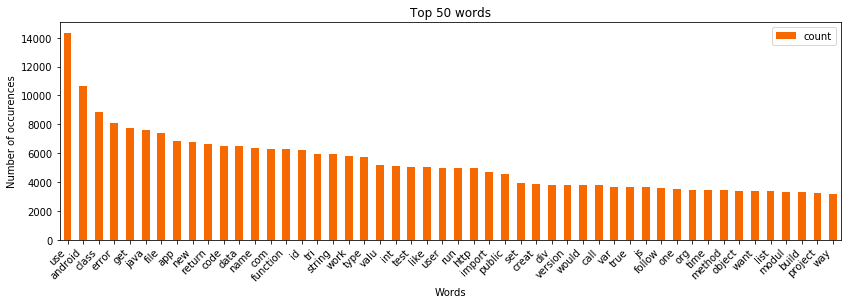

In [22]:
ax = voc_freq_df.head(50).plot(kind = 'bar', figsize = (14,4), color="#f56900")
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
plt.title('Top 50 words', fontsize = 'large')
plt.xlabel('Words')
plt.ylabel('Number of occurences')
plt.show()

use, android, error, class ... sont très fréquents

####  Sparsicity de la matrice

Regardons le pourcentage de cellules non égales à 0.

In [23]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity:  {:.2f} %".format( ((data_dense > 0).sum()/data_dense.size)*100, "%"))

Sparsicity:  2.91 %


# 3. Modélisation avec méthodes non supervisées

## 3.1 LDA

### Construction du modèle et recherche sur grille

In [24]:
# Define Search Param
search_params = {'n_components': [10, 20, 30, 50 ], 'learning_method':['batch'], 'max_iter':[10]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
lda_model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
lda_model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 20, 30, 50], 'learning_method': ['batch'], 'max_iter': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Voyons les hyper-paramètres qui donnent la meilleure performance.

In [25]:
lda_model.best_params_

{'learning_method': 'batch', 'max_iter': 10, 'n_components': 20}

Nous pouvons partir sur 20 topics.

In [26]:
best_lda_model = lda_model.best_estimator_

In [27]:
lda_output = best_lda_model.transform(data_vectorized)

In [28]:
lda_output.shape

(9774, 20)

### Evaluation

Regardons le score likehood de notre modèle.

In [29]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", best_lda_model.score(data_vectorized))

Log Likelihood:  -6920341.77208


### Analyse des résultats

#### Topics / Words

Affichage des top words pour chaque topics.

In [30]:
# liste des topics
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# Topic-Keyword Matrice
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
df_topic_keywords.columns = vocab
df_topic_keywords.index = topicnames

df_topic_keywords.head()

,aa,ab,abc,abl,abort,absolut,abstract,accept,access,accord,...,yarn,ye,year,yet,yield,zero,zip,zn,zone,zygoteinit
Topic0,1.990177,0.050001,4.351391,122.513430,0.050000,28.778580,0.050000,10.927748,1.200002,24.123781,...,66.891666,33.541669,0.050000,33.505145,0.050000,12.927170,122.193307,0.05000,0.077615,0.050000
Topic1,0.050000,10.307542,14.366572,41.536629,0.050000,0.050000,0.050000,112.284024,509.061815,0.050000,...,101.235532,0.050000,0.050000,6.739512,10.854966,0.050000,0.050000,0.05000,0.050000,0.050000
Topic2,2.362424,0.050000,7.176521,2.742350,0.050000,3.805201,5.616621,3.989471,98.995050,0.105018,...,0.050000,0.050000,0.050000,4.880271,0.050000,0.050000,7.237842,0.05000,0.050000,28.793091
Topic3,0.050000,0.050000,0.050000,31.311681,0.061502,23.309727,0.824302,10.844585,59.413151,0.732542,...,0.050000,0.050000,0.050000,9.272910,0.468470,0.050000,0.050000,0.05000,159.496798,0.050000
Topic4,22.490186,0.050000,0.050000,1.793539,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,4.752647,0.053117,3.759190,0.050000,87.002655,0.050000,223.93072,0.050000,0.050000


In [31]:
# Show top n keywords for each topic
def show_topics(feature_names, lda_model, n_words=20):
    keywords = np.array(feature_names)
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [32]:
topic_keywords = show_topics(vocab, best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,build,project,file,instal,error,version,use,run,packag,tri
Topic 1,http,api,request,com,token,org,client,respons,header,url
Topic 2,java,org,com,intern,core,lang,gradl,run,net,class
Topic 3,js,compon,angular,import,modul,react,app,node,error,export
Topic 4,time,long,doubl,font,note,xmm,br,myapp,size,result
Topic 5,id,name,user,valu,select,type,get,form,queri,field
Topic 6,use,like,would,way,one,question,want,exampl,need,work
Topic 7,system,includ,microsoft,visual,studio,net,window,use,code,except
Topic 8,self,let,func,view,swift,io,return,var,code,print
Topic 9,int,std,foo,type,const,function,templat,return,class,void


Nous pouvons interpréter certains topics : <br/>
- le sujet 6 : web dev (react, angular, ...)
- Le sujet 16 : androïd 
- Le sujet 24 : microsoft
...

In [33]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [34]:
#no_top_words = 10
#display_topics(best_lda_model, vocab, no_top_words)

#### Topics / Docs

Voyons maintenant le topic associé à quelques documents.

In [35]:
'''
@H : word_to_topics matrix
@W : topics_to_docs matrix
'''
def display_topics(H, W, feature_names, documents, targets, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d : " % (topic_idx) + " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print ("Doc",doc_index," Title:", documents.iloc[doc_index].TITLE[0:60],
                   "- Tags:[", targets.iloc[doc_index].TAGS_P,"]")
        print("")

In [36]:
display_topics(best_lda_model.components_, lda_output, vocab, x_train, y_train, 10, 2)

Topic 0 : build project file instal error version use run packag tri
Doc 9500  Title: `npm install` ends with "Killed" - Tags:[ javascript node.js linux ubuntu npm ]
Doc 4158  Title: R 3.3.0 installing a package on Windows: gcc not found error - Tags:[ r gcc ]

Topic 1 : http api request com token org client respons header url
Doc 2964  Title: Unauthorized in spring boot admin - Tags:[ spring spring-boot ]
Doc 5412  Title: Enable http2 with Tomcat in Spring Boot - Tags:[ spring-boot ]

Topic 2 : java org com intern core lang gradl run net class
Doc 4592  Title: Disabling WADL in WebLogic12.2.1 - Tags:[ java rest ]
Doc 6226  Title: Extension API internal error: org.powermock.api.extension.re - Tags:[ java eclipse ]

Topic 3 : js compon angular import modul react app node error export
Doc 4144  Title: ngmodule.type - cannot read property type of null - main.js - Tags:[ angular ]
Doc 7382  Title: ng2-translate not working in lazy-loaded module - Tags:[ angular angular2-routing ]

Topic 4 

- **Stockons pour chaque document, le topic prédominant**

In [37]:
# id des posts
docnames = ["Doc" + str(i) for i in range(len(x_train))]

# On crée un dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 4), columns=topicnames, index=docnames)

# On rajoute une colonne contenant le numéro du topic prédominant
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [38]:
df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.0021,0.0021,0.0021,0.0021,0.0991,0.1691,0.0021,0.0021,0.2505,0.0021,...,0.0021,0.0021,0.0021,0.0021,0.0021,0.0021,0.4481,0.0021,0.0021,17
Doc1,0.0004,0.0004,0.0004,0.0004,0.0004,0.0004,0.0004,0.0310,0.0004,0.1089,...,0.0004,0.0004,0.0004,0.0004,0.0004,0.0004,0.0004,0.0244,0.8299,19
Doc2,0.0005,0.0005,0.0005,0.1216,0.0679,0.0005,0.4248,0.0694,0.0172,0.0005,...,0.2212,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.0718,6
Doc3,0.4607,0.0007,0.0185,0.2158,0.0007,0.0007,0.1629,0.0007,0.1310,0.0007,...,0.0007,0.0007,0.0007,0.0007,0.0007,0.0007,0.0007,0.0007,0.0007,0
Doc4,0.0011,0.0011,0.0011,0.0011,0.0011,0.0011,0.4961,0.0011,0.0011,0.2667,...,0.0011,0.0230,0.0011,0.1965,0.0011,0.0011,0.0011,0.0011,0.0011,6
Doc5,0.0009,0.0704,0.0009,0.0009,0.0009,0.0009,0.4254,0.0009,0.4551,0.0009,...,0.0353,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,8
Doc6,0.4059,0.0014,0.0014,0.0014,0.0014,0.0014,0.0014,0.0014,0.0014,0.0014,...,0.0014,0.0014,0.0014,0.0014,0.0014,0.5684,0.0014,0.0014,0.0014,16
Doc7,0.1554,0.0003,0.0003,0.0003,0.0003,0.0118,0.0003,0.0003,0.0003,0.0003,...,0.0003,0.8050,0.0003,0.0235,0.0003,0.0003,0.0003,0.0003,0.0003,12
Doc8,0.0005,0.1764,0.0005,0.0005,0.0005,0.0005,0.3094,0.0005,0.0005,0.0005,...,0.0005,0.0005,0.0005,0.0005,0.0005,0.3077,0.0005,0.0005,0.0778,6
Doc9,0.1344,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.5455,...,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.2796,0.0024,9


- **Voyons la distribution des topics par documents**

In [39]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,6,1787
1,0,1011
2,17,864
3,18,737
4,9,717
5,3,698
6,19,583
7,5,510
8,10,460
9,8,426


## Prédiction

### Text cleaning and processing

Reprenons le code des méthodes utilisées pour la partie cleaning du texte et pré-processing.

In [40]:
stopword_list = set(stopwords.words('english'))
tokenizer = ToktokTokenizer()

'''
Méthode qui permet de mettre les contractions dans une forme classique.
Méthode récupéré depuis github : (c) @dipanjanS
'''
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


# stemming of words
def stem_text(word) :
    porter = PorterStemmer()
    return porter.stem(word)


def getCleanedText(text) :
    # remove html tags
    text = BeautifulSoup(text, "lxml").get_text()
    
    # remove accented char
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = expand_contractions(text)
    
    # remove non alpha char
    text = re.sub('[\W\d_]', ' ', text)

    # convert to lower case
    text = text.lower()
  
    #remove extra newlines
    text = re.sub(r'[\r|\n|\r\n]+', ' ',text)
    
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    
    # Remove any single letter except 'c' (correspond au langage)
    text = ' '.join( [w for w in text.split() if len(w)>1 or w == 'c'] )
    
    # remove stopwords
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    meaningful_words = [token for token in tokens if token not in stopword_list]
    
    # stemming of words
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in meaningful_words]
    
    # join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( stemmed )) 

### Topic prediction

Ecrivons une méthode qui va, par le biais de LDA, retrouver le topic prédominant d'un texte.

In [41]:
def predictTextTopic(text) :
    text = getCleanedText(text)
    text_vectorized = cv.transform([text])
    topic_probability_scores = best_lda_model.transform(text_vectorized)
    best_topicId = np.argmax(topic_probability_scores)
    return best_topicId

### Topic to tags

Essayons de déterminer pour chacun des topics, les tags qu'on peut lui associer.

In [42]:
topic_tags = {}
for topic_idx, topic in enumerate(best_lda_model.components_):
    topic_tags[topic_idx] = []
    for i in (topic.argsort()[:-100 - 1:-1]) :
        word = vocab[i]
        if stem_text(word) in frequent_tags :
            t = topic_tags[topic_idx]
            t.extend([word])
print(topic_tags)

{0: ['npm', 'http', 'git', 'json', 'xcode', 'github', 'linux', 'go'], 1: ['http', 'spring', 'scala', 'json', 'rest', 'maven', 'facebook', 'xml'], 2: ['java', 'xml', 'http', 'maven', 'kotlin', 'string'], 3: ['angular', 'function', 'webpack', 'html', 'http', 'css', 'redux', 'typescript', 'json', 'javascript'], 4: ['list', 'function'], 5: ['list', 'function', 'string', 'php', 'json', 'html'], 6: ['function', 'go', 'sql'], 7: ['xamarin', 'string'], 8: ['swift', 'xcode', 'function', 'string'], 9: ['function', 'kotlin', 'gcc', 'string', 'clang', 'express', 'lambda', 'opencv'], 10: ['html', 'css', 'function', 'http', 'javascript', 'list'], 11: ['excel', 'html'], 12: ['python', 'django', 'tensorflow', 'sql', 'ssl', 'json'], 13: ['android', 'http', 'java', 'xml', 'string', 'cordova'], 14: ['tensorflow', 'function', 'laravel'], 15: ['selenium', 'http', 'tensorflow'], 16: ['string', 'list'], 17: ['list', 'string', 'function', 'regex', 'javascript'], 18: ['string', 'function'], 19: ['php', 'docker

In [43]:
def getTopicRelatedTags(topicId):
    return topic_tags[topicId]

In [44]:
id = 8
test_text = x_train.iloc[id]['TITLE'] + ' ' + x_train.iloc[id]['TITLE']
predicted_topic = predictTextTopic(test_text)
print("predicted_topic:",predicted_topic)
predicted_tags = getTopicRelatedTags(predicted_topic)
print(predicted_tags, " -> [" , y_train.iloc[id]['TAGS_P'],"]")

predicted_topic: 6
['function', 'go', 'sql']  -> [ php laravel ]


## 3.2 NMF

In [45]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5,max_features=1700)
tfidf = tfidf_vectorizer.fit_transform(x_train_text)
tfidf_matrix = tfidf.toarray()
tfidf_matrix.shape

Extracting tf-idf features for NMF...


(9774, 1700)

In [46]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [47]:
nmf = NMF(n_components=30, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

In [48]:
nmf_output = nmf.transform(tfidf)

In [49]:
nmf_output.shape

(9774, 30)

In [50]:
topic_keywords = show_topics(tfidf_feature_names, nmf, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,use,would,like,way,one,code,time,work,want,differ
Topic 1,android,layout,support,com,view,studio,app,id,dp,parent
Topic 2,int,const,compil,return,main,char,void,includ,printf,oper
Topic 3,div,px,class,text,button,span,height,width,item,css
Topic 4,angular,ng,cli,import,core,ts,http,browser,app,direct
Topic 5,public,class,void,new,privat,overrid,static,method,return,interfac
Topic 6,java,org,lang,com,activitythread,intern,apach,util,method,sun
Topic 7,tabl,column,id,row,df,select,date,queri,valu,datafram
Topic 8,request,http,respons,server,error,url,header,api,client,token
Topic 9,python,py,instal,import,packag,lib,line,pip,modul,usr


In [51]:
topicnames = ["Topic" + str(i) for i in range(nmf.n_components)]

# id des posts
docnames = ["Doc" + str(i) for i in range(len(x_train))]

# On crée un dataframe
df_document_topic = pd.DataFrame(np.round(nmf_output, 4), columns=topicnames, index=docnames)

# On rajoute une colonne contenant le numéro du topic prédominant
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [52]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0.0061,0.0000,0.0009,0.0,0.0000,0.0,0.0000,0.0,0.0064,0.0000,...,0.0021,0.0221,0.0,0.0008,0.0,0.0,0.0,0.0004,0.0000,20
Doc1,0.0019,0.0000,0.0001,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,...,0.0000,0.0000,0.0,0.0223,0.0,0.0,0.0,0.0000,0.0006,11
Doc2,0.0330,0.0000,0.0000,0.0,0.0000,0.0,0.0024,0.0,0.0000,0.0000,...,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0046,0.0047,0
Doc3,0.0087,0.0023,0.0000,0.0,0.0001,0.0,0.0000,0.0,0.0000,0.0000,...,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0000,16
Doc4,0.0123,0.0000,0.0591,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0102,...,0.0000,0.0000,0.0,0.0378,0.0,0.0,0.0,0.0000,0.0258,2
